In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
import tracemalloc


# from importlib import reload

In [2]:
import dask
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=10,processes=False,memory_limit='50gb',threads_per_worker=1,memory_spill_fraction=.99,)
#                memory_monitor_interval='2000ms',worker_memory_limit='50gb')
client=Client(LC)
# dask.config.set(scheduler='single-threaded')

In [3]:
client

Client Scheduler: inproc://136.152.250.183/14129/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [4]:
client.restart()

Client Scheduler: inproc://136.152.250.183/14129/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [5]:
from cov_3X2 import *
# from fisher import *

In [6]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [7]:
from lsst_utils import *

In [8]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import window_utils
reload(window_utils)
from window_utils import *

In [10]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [11]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [12]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'Ase9': 1.685,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166462048332

In [13]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [14]:
use_window=True
do_sample_variance=True
SSV_cov=True
tidal_SSV=True
Tri_cov=False
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [15]:
f_sky=.7 #3000./(4*np.pi/d2r**2)
f_sky

nside=128

In [16]:
f_sky

0.7

In [17]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,use_window=use_window,f_sky=f_sky,window_cl_fact=0,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),sigma_gamma=sigma_gamma,
                        zp_sigma=z_sigma*np.ones_like(z),nside=nside)

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=1 # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),window_cl_fact=0,
                        zp_sigma=z_sigma*np.ones_like(z),k_max=1.e6,nside=nside)
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [18]:
for a in ()+("X",):
    print (a)

X


In [19]:
do_cov=True

In [20]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [21]:
#Hankel Transform setup
l_max=1e3
l_maxW=1e3
l_min=2
# nl=1e2
# nl_bins=np.int(nl/10)
# l0=np.logspace(np.log10(l_min),np.log10(l_maxW),nl)
# l0=np.append([0,1],l0)
# l0=np.unique(np.int32(l0))
# l0_HT=l0
l0=np.arange(l_min,l_max)
l0_HT=np.arange(l_max)
nl_bins=20
  #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
# l_bins=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),50)))
l_bins=np.unique(np.int32(np.linspace(l_min,l_max,nl_bins)))
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [22]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [23]:
corr_ggl=('shear','galaxy')
corr_ggk=('kappa','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
m1m2=(0,2)
m1m2_gg=(0,0)

In [24]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0_HT,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

./wigner_functions.py:38: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 436 ms, sys: 810 ms, total: 1.25 s
Wall time: 2.11 s


In [25]:
window_lmax=30
bi=(0,0)



In [26]:
import window_utils
reload(window_utils)
from window_utils import *

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [27]:
np.int8(1)

1

In [28]:
do_cov=True
use_window=True
SSV_cov=True

In [29]:
tracemalloc.clear_traces()
tracemalloc.start()

t1=time.time()
try:
    Win=XI_W_L.Win.Win
except:
    Win=None
XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_gg,corr_ggl]
                ,store_win=True,Win=Win,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
t2=time.time()
snapshot1 = tracemalloc.take_snapshot()
print('W done',t2-t1)
top_stats = snapshot1.statistics('lineno')

wigner_files: {0: 'temp/dask_wig3j_l3000_w500_0_reorder.zarr', 2: 'temp/dask_wig3j_l3000_w500_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.183/14129/1' processes=10 cores=10>
Cl windows done, now to covariance
mask-comb fsky: 0.6999969482421875
mask-comb fsky: 0.6999969482421875
mask-comb fsky: 0.6999969482421875
mask-comb fsky: 0.6999969482421875
mask-comb fsky: 0.6999969482421875
mask-comb fsky: 0.6999969482421875
W done 2.96806263923645


In [30]:
top_stats = snapshot1.statistics('traceback')

In [31]:
tracemalloc.get_traced_memory()

(175450152, 2599760726)

In [32]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

34 memory blocks: 62.5 MiB
  File "/usr/lib/python3.7/site-packages/numpy/core/einsumfunc.py", line 1346
    return c_einsum(*operands, **kwargs)


In [33]:
top_stats

[<Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/einsumfunc.py' lineno=1346>,)> size=65524208 count=34>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/sparse/coo/core.py' lineno=234>,)> size=46141992 count=6>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=384>,)> size=32000704 count=18>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=383>,)> size=32000640 count=16>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=75>,)> size=31000080 count=2>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=247>,)> size=24000240 count=6>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/numeric.py' lineno=1203>,)> size=8000080 count=2>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=249>,)> size=8000080 count=2>,
 <Statistic tra

In [34]:
%time clG=XI_W_L.cl_tomo()

added extra corr calc for covariance [('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 6.68 s, sys: 53.6 ms, total: 6.73 s
Wall time: 1.26 s


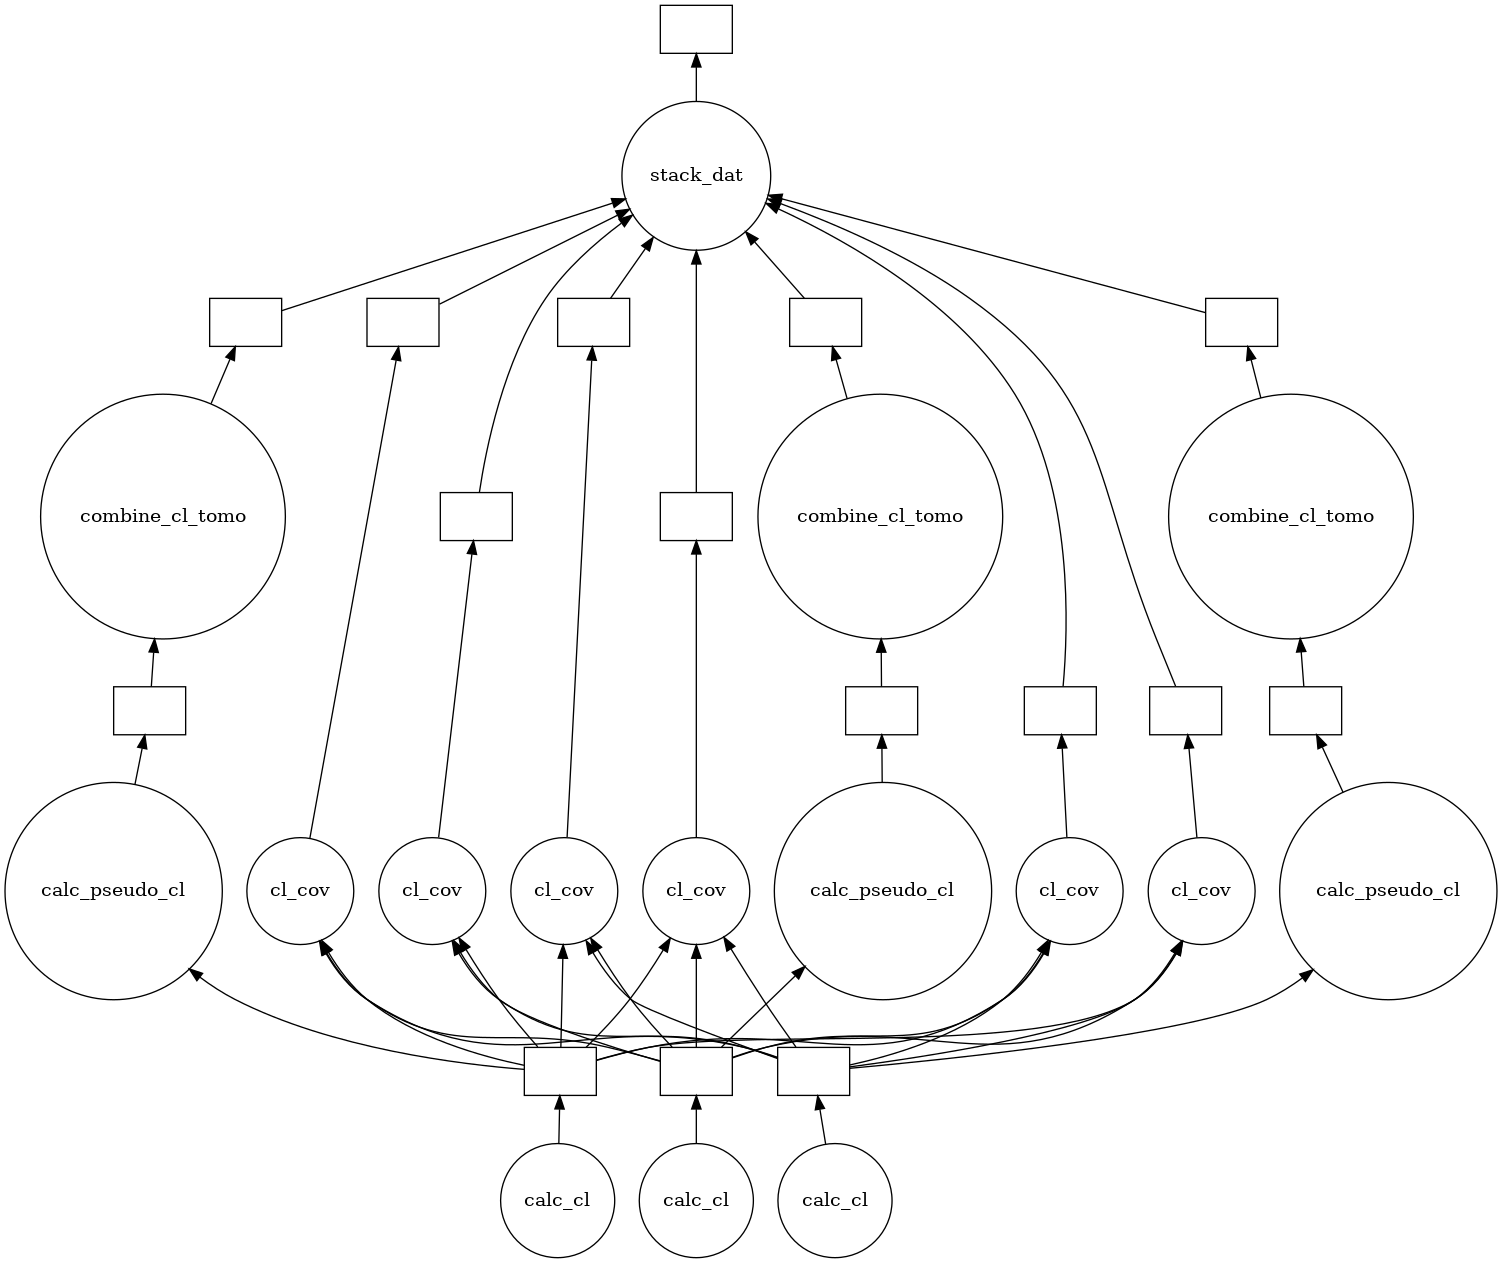

In [35]:
clG['stack'].visualize()

In [36]:
%time cl_L=clG['stack'].compute()

CPU times: user 13.1 s, sys: 98.9 ms, total: 13.2 s
Wall time: 2.39 s


In [37]:
cl=clG['cl'][corr_ll][bi].compute()
pcl=clG['cl_b'][corr_ll][bi].compute()

In [38]:
lb=0.5*(XI_W_L.l_bins[1:]+XI_W_L.l_bins[:-1])

[]

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


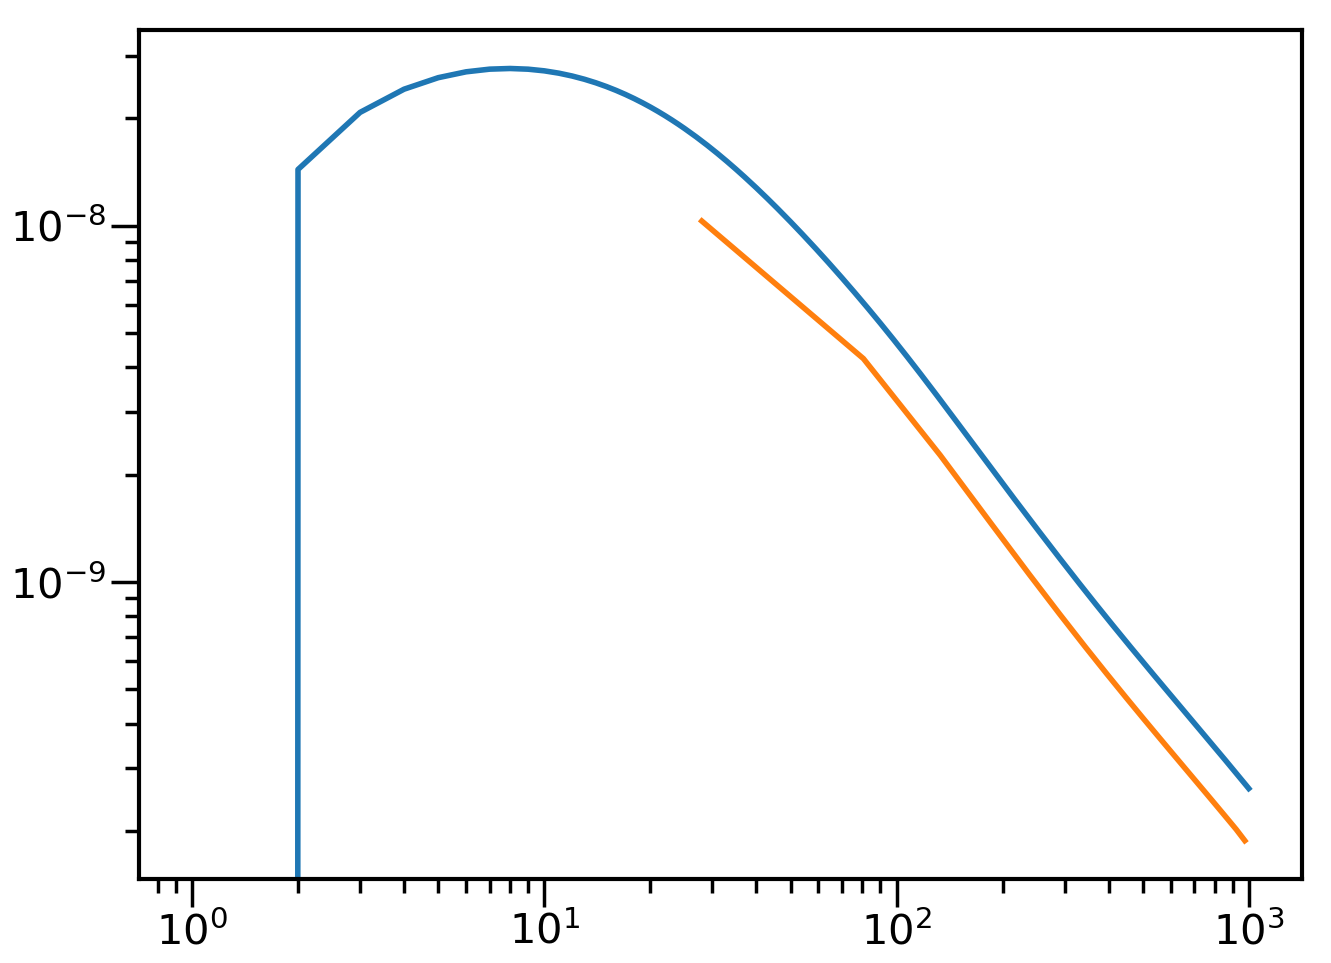

In [39]:
plot(XI_W_L.l,cl)
plot(lb,pcl)
loglog()

In [40]:
A=np.int8(np.eye(1000))
X=np.float32(np.eye(1000))

In [41]:
A

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [42]:
B=A.astype('bool')

In [43]:
%time x1=X*A
%time x2=X*B

CPU times: user 4.05 ms, sys: 189 µs, total: 4.24 ms
Wall time: 2.27 ms
CPU times: user 4.3 ms, sys: 93 µs, total: 4.39 ms
Wall time: 2.18 ms


In [44]:
np.all(x1==x2)

True

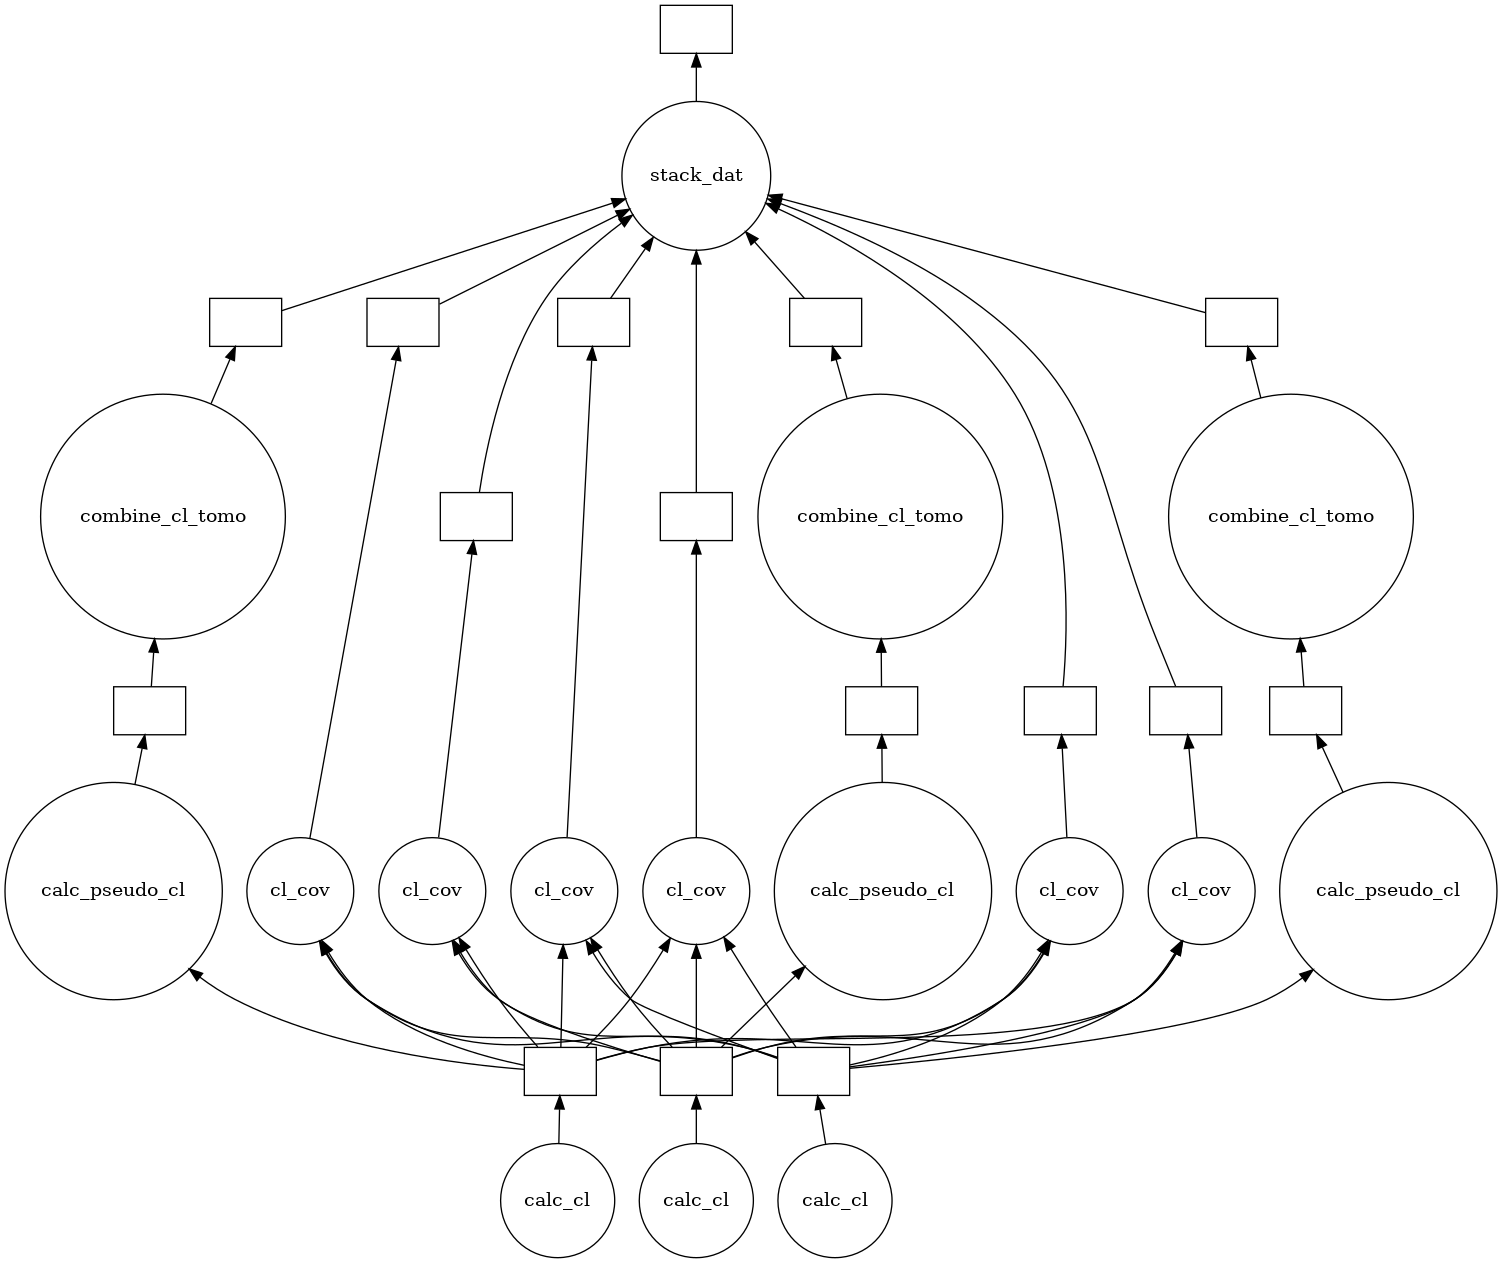

In [45]:
dask.visualize(clG['stack'])

In [46]:
np.arange(1000,step=300)

array([  0, 300, 600, 900])

In [47]:
XI_W_L.Win.Win['cl'][corr_ll][bi]

{'corr': ('shear', 'shear'),
 'indxs': (0, 0),
 'cl': array([6.15746550e+00, 5.54182875e-01, 8.86680731e-02, 1.38670174e-03,
        1.95871942e-02, 4.27230043e-03, 1.51312322e-03, 4.37305093e-03,
        3.30071108e-04, 1.15243898e-03, 1.34382903e-03, 3.40176101e-07,
        7.87217755e-04, 4.08090992e-04, 6.26615058e-05, 4.90237393e-04,
        9.31221594e-05, 1.29637332e-04, 2.72453570e-04, 6.62551661e-06,
        1.50367130e-04, 1.28518399e-04, 4.93411729e-06, 1.33561273e-04,
        4.58934732e-05, 2.63529652e-05, 9.77190892e-05, 8.59413921e-06,
        4.43522079e-05, 5.89665691e-05, 1.43399188e-07]),
 'W_pm': 2,
 'm1m2': array([2, 2, 2, 2]),
 'xi': array([0.69522465, 0.69522465, 0.69522464, ..., 0.68972903, 0.68971635,
        0.68970366]),
 'xi_b': array([0.69522446, 0.69522401, 0.6952233 , 0.69522219, 0.69522042,
        0.69521762, 0.69521318, 0.69520616, 0.69519504, 0.69517728,
        0.69514917, 0.69510487, 0.69503484, 0.69492433, 0.69474978,
        0.69447507, 0.69404562

In [48]:
XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.82561138e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.14768490e-07, 6.50088952e-07, 3.71439994e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.50740671e-07, 9.12937314e-07, 6.48788639e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.72184736e-07, 6.49438402e-07, 9.11111684e-07]])

In [49]:
# M2=XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2].compute()
try:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B'].compute()
except:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B']
XI_W_L.SN[corr_ll][:,0,0]@M2n

array([0.00000000e+00, 0.00000000e+00, 3.88874967e-11, 2.73319966e-11,
       1.96765684e-11, 1.61590855e-11, 1.34835983e-11, 1.14336259e-11,
       1.00776349e-11, 8.88522092e-12, 7.94733968e-12, 7.21816561e-12,
       6.54965978e-12, 6.01504962e-12, 5.55394029e-12, 5.13191547e-12,
       4.78484852e-12, 4.46552068e-12, 4.17827691e-12, 3.93220973e-12,
       3.69873319e-12, 3.49192462e-12, 3.30642700e-12, 3.12967582e-12,
       2.97361704e-12, 2.82787023e-12, 2.69062166e-12, 2.56797476e-12,
       2.45037986e-12, 2.34142211e-12, 2.24171879e-12, 2.14524487e-12,
       2.05248328e-12, 1.96370962e-12, 1.87904315e-12, 1.79849450e-12,
       1.72200000e-12, 1.64944643e-12, 1.58068868e-12, 1.51556224e-12,
       1.45389229e-12, 1.39550015e-12, 1.34020752e-12, 1.28783971e-12,
       1.23822761e-12, 1.19120902e-12, 1.14662942e-12, 1.10434235e-12,
       1.06420951e-12, 1.02610082e-12, 9.89894044e-13, 9.55474667e-13,
       9.22735429e-13, 8.91576022e-13, 8.61902728e-13, 8.33627938e-13,
      

[]

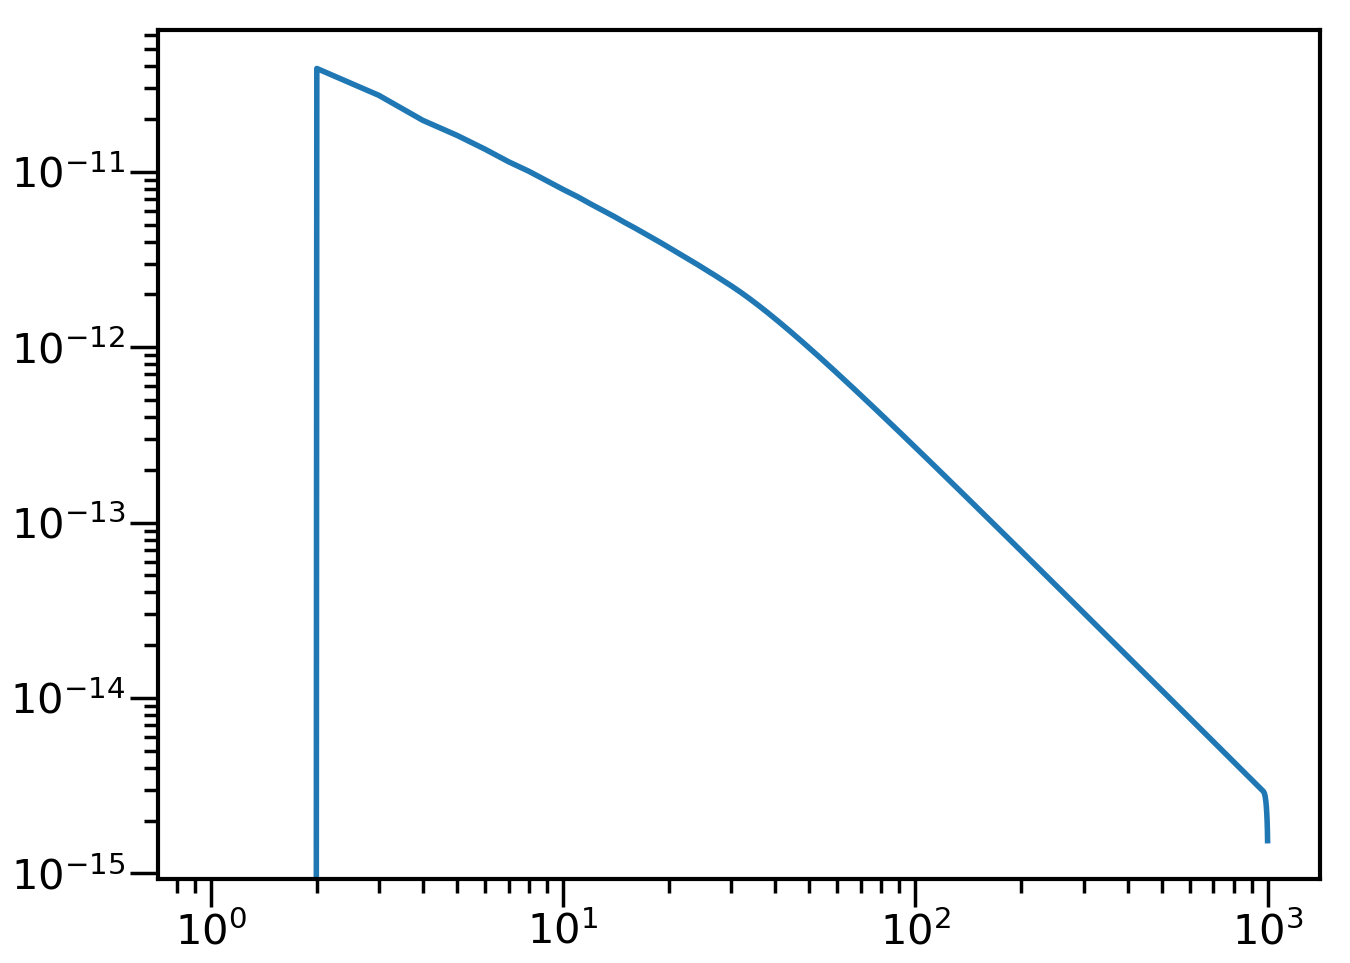

In [50]:
bi=(0,0)
f=1#XI_W_L.l**2
# plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2]))
plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@M2n))
loglog()

In [51]:
XI_W_L_NW= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins, #no window
                do_sample_variance=do_sample_variance,use_window=False,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],store_win=True,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
print('NW done')

NW done


./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


In [52]:
# %time clG=XI_W_L.cl_tomo()
%time clG_nw=XI_W_L_NW.cl_tomo()
#%time clH=XI_H.cl_tomo()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 6.72 s, sys: 41 ms, total: 6.76 s
Wall time: 1.21 s


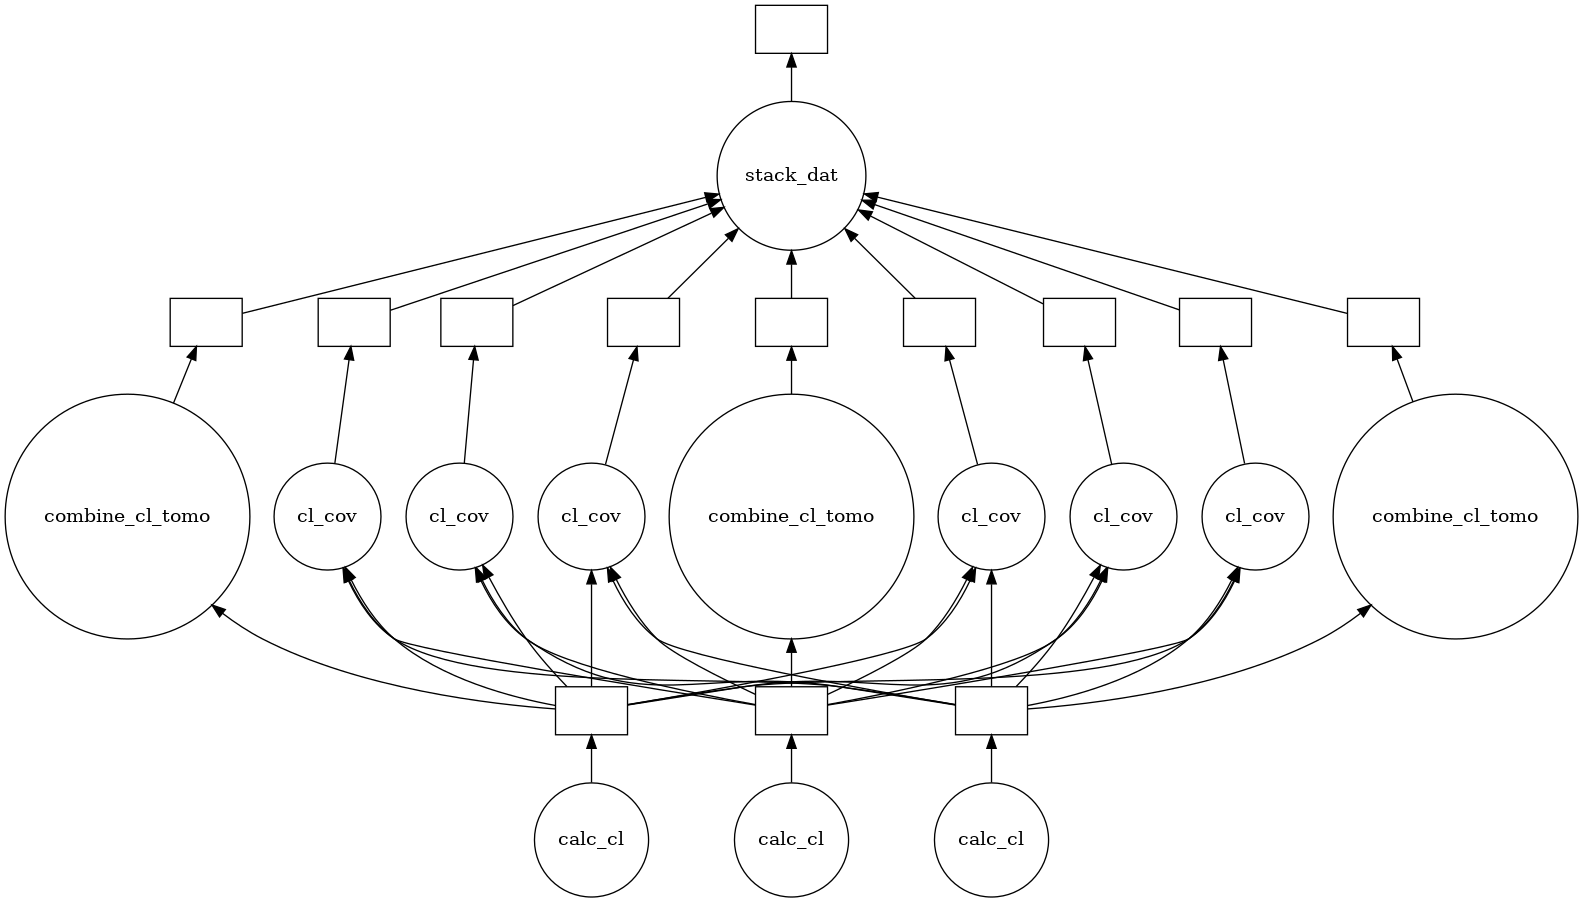

In [53]:
clG_nw['stack'].visualize()

In [54]:
%time cl_L_nw=clG_nw['stack'].compute()

CPU times: user 639 ms, sys: 49.5 ms, total: 689 ms
Wall time: 269 ms


In [55]:
clG['cl'].keys()

dict_keys([('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')])

In [56]:
bi=(0,0)
corr=corr_ll
cov_t=clG['cov'][corr+corr][(0,0,0,0)].compute()
cl_bt=clG['cl_b'][corr][(0,0)].compute()
cl_btnw=clG_nw['cl_b'][corr][(0,0)].compute()
cov_tnw=clG_nw['cov'][corr+corr][(0,0,0,0)].compute()

In [57]:
np.sqrt(cov_tnw['SSC_b']/cov_t['SSC_b'])

array([[0.97611457, 0.97827984, 0.9762146 , 0.97677465, 0.9784865 ,
        0.98062616, 0.98284913, 0.98502754, 0.98709171, 0.98903284,
        0.99084304, 0.99253   , 0.99410019, 0.9955557 , 0.99690562,
        0.99819162, 0.99936434, 1.00047672, 1.00153337],
       [0.97827984, 0.98133282, 0.97893679, 0.97930182, 0.98095544,
        0.98312799, 0.98544062, 0.98773776, 0.98993582, 0.99201886,
        0.9939724 , 0.99579998, 0.99750774, 0.99909719, 1.00057731,
        1.00198712, 1.00328221, 1.00451035, 1.00568118],
       [0.9762146 , 0.97893679, 0.97642574, 0.97666283, 0.97820965,
        0.9802859 , 0.98251054, 0.98473268, 0.98686664, 0.98889448,
        0.99080073, 0.99258586, 0.99425632, 0.9958145 , 0.99726844,
        0.99864811, 0.99992415, 1.00113076, 1.00228196],
       [0.97677465, 0.97930182, 0.97666283, 0.97676639, 0.97815465,
        0.98008823, 0.98218201, 0.98428313, 0.98630681, 0.98823352,
        0.99004689, 0.99174622, 0.99333796, 0.99482333, 0.99621062,
        0.997

[]

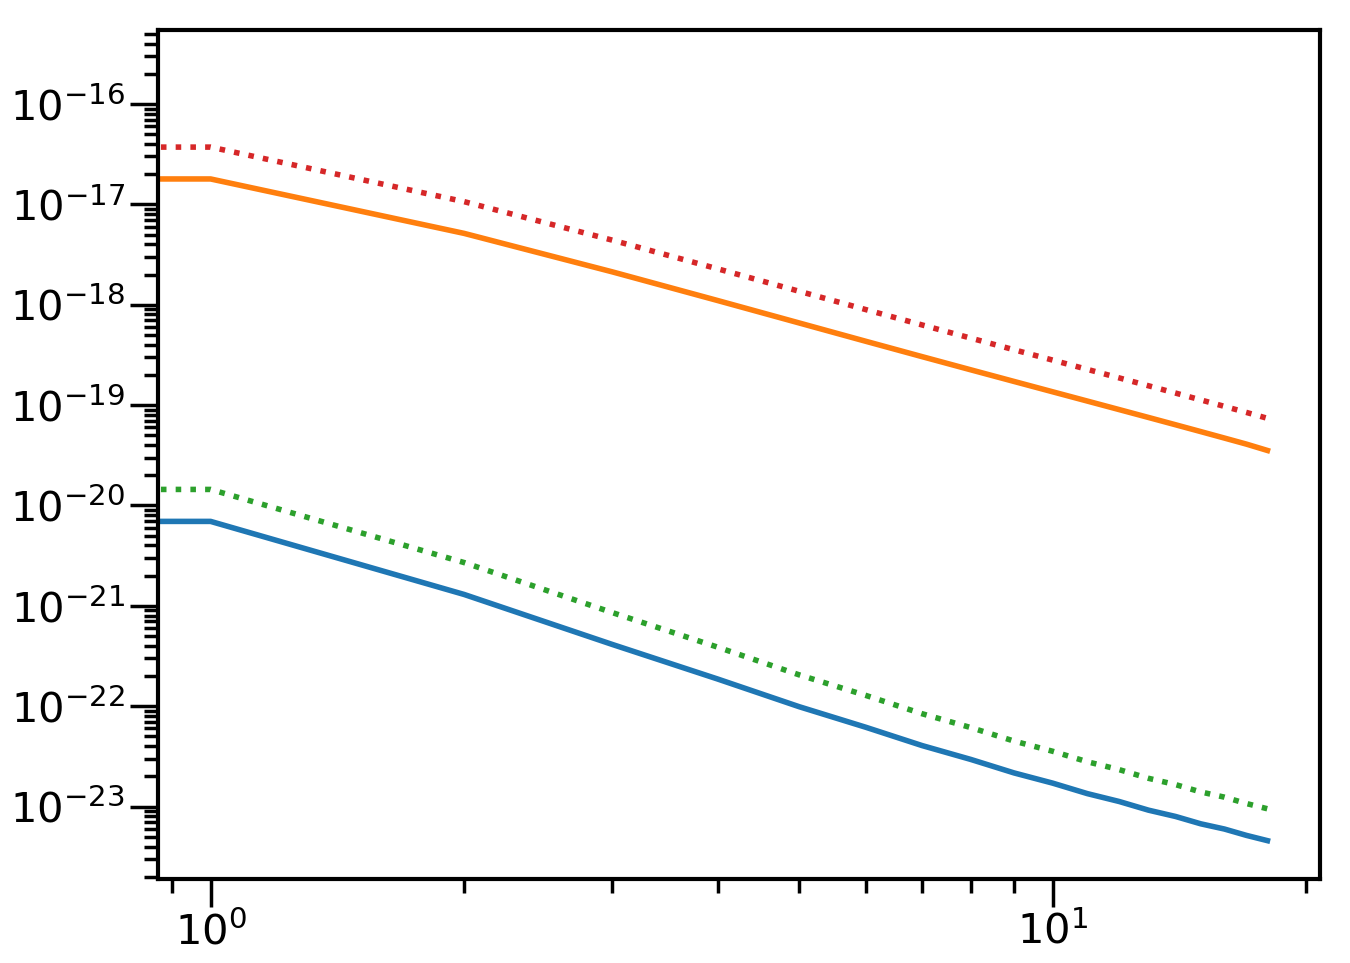

In [58]:
plot(np.diag(cov_t['final_b']))
plot(cl_bt**2)
plot(np.diag(cov_tnw['final_b']),':')
plot(cl_btnw**2,':')
loglog()

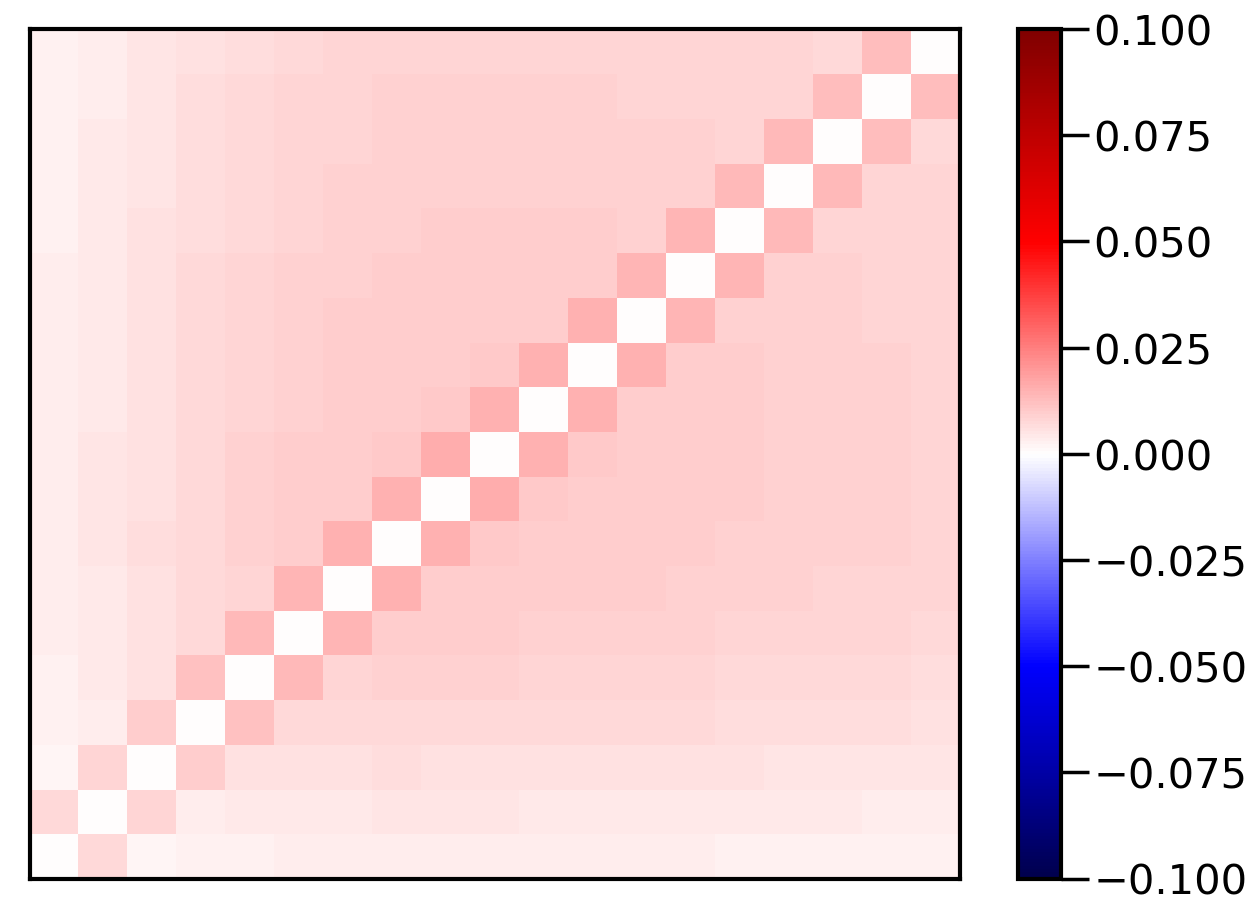

In [59]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cov_t['final_b'])
corrW-=np.diag(np.diag(corrW))
pcolor(corrW,vmin=-.1,vmax=.1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()



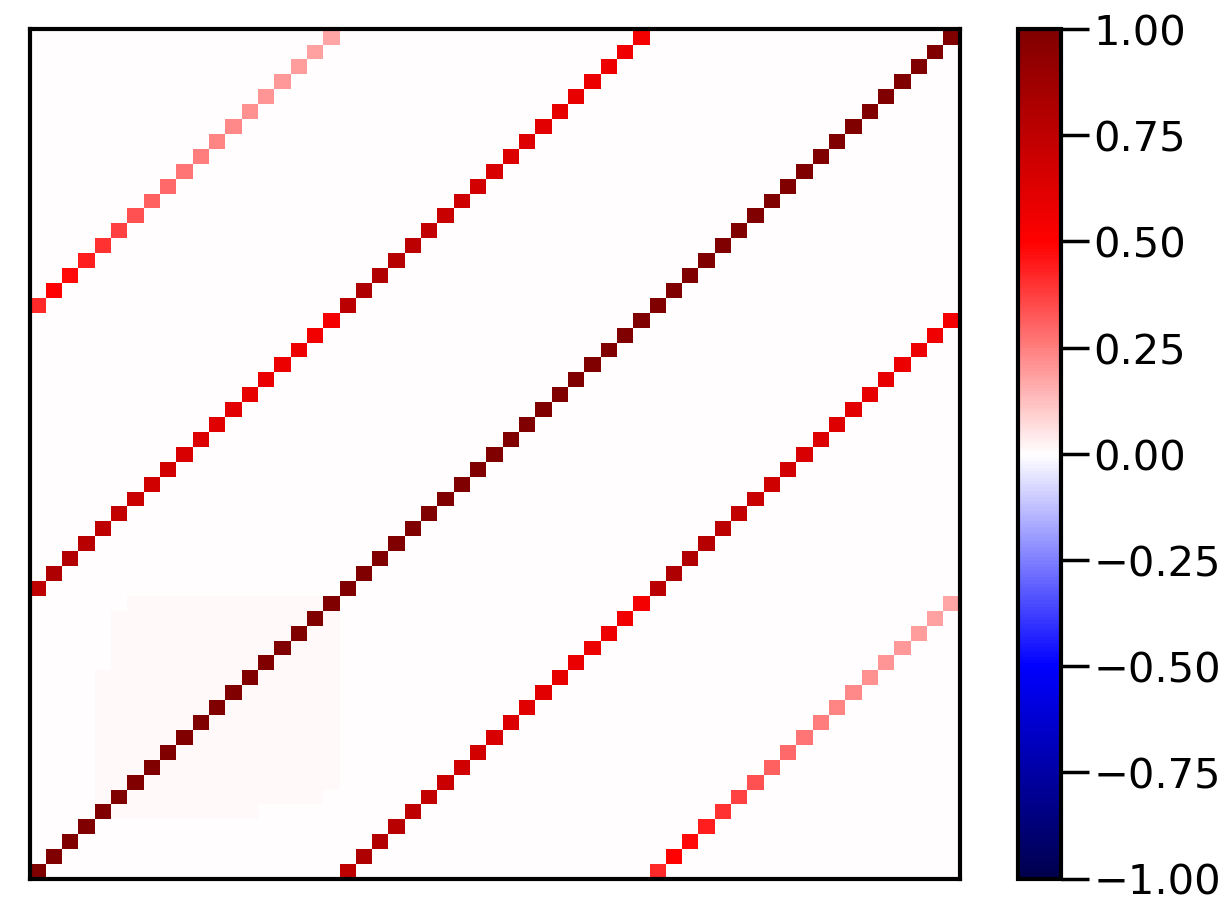

In [60]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()


In [61]:
XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['Om_w'],XI_W_L_NW.cov_utils.Om_W

(8.796421080531724, 8.79645943005142)

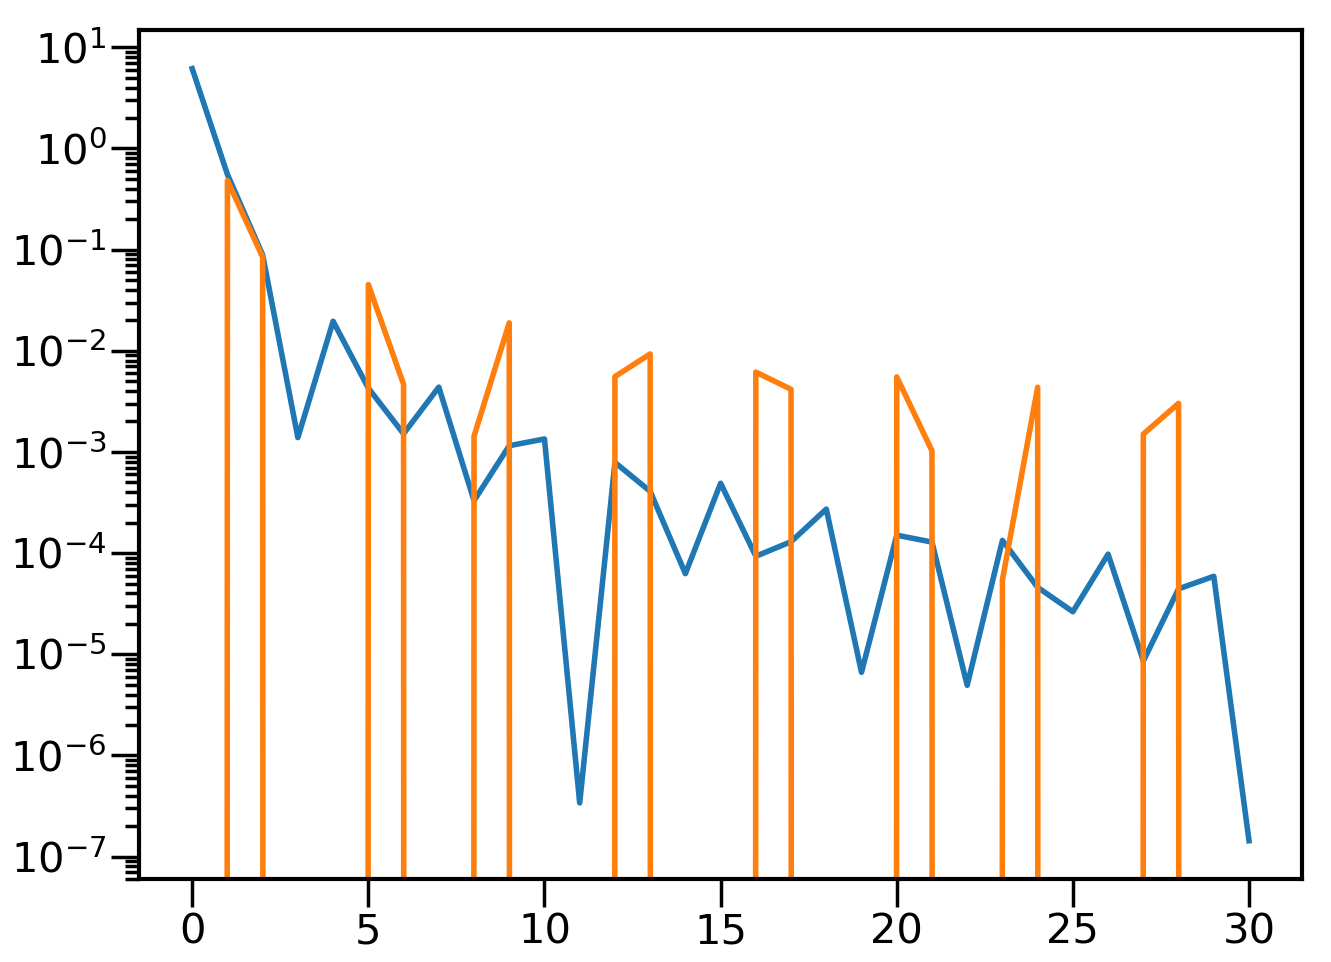

In [62]:
plot(XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['mask_comb_cl'])
plot(XI_W_L_NW.cov_utils.Win)
yscale('log')

In [63]:
XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['mask_comb_cl']

array([6.15746704e+00, 5.54184650e-01, 8.86679629e-02, 1.38659465e-03,
       1.95872208e-02, 4.27211078e-03, 1.51311100e-03, 4.37322355e-03,
       3.30063567e-04, 1.15234933e-03, 1.34384015e-03, 3.39595885e-07,
       7.87210931e-04, 4.08147423e-04, 6.26642524e-05, 4.90179415e-04,
       9.31258077e-05, 1.29668205e-04, 2.72448956e-04, 6.63275203e-06,
       1.50370468e-04, 1.28487418e-04, 4.93332748e-06, 1.33591717e-04,
       4.58911107e-05, 2.63388395e-05, 9.77217431e-05, 8.58592506e-06,
       4.43502332e-05, 5.89872355e-05, 1.43458308e-07])

In [64]:
XI_W_L_NW.f_sky

{('shear', 'shear'): {(0, 0): array(0.7)},
 ('galaxy', 'galaxy'): {(0, 0): array(0.7)},
 ('kappa', 'kappa'): {},
 ('shear', 'galaxy'): {(0, 0): array(0.7)},
 ('galaxy', 'shear'): {(0, 0): array(0.7)}}

In [65]:
XI_W_L_NW.cov_utils.Win

array([ 0.00000000e+00,  4.81972991e-01,  8.42559039e-02, -9.19626382e-02,
       -2.03626747e-02,  4.50795462e-02,  4.66711764e-03, -2.78844870e-02,
        1.43138620e-03,  1.88780540e-02, -4.23309850e-03, -1.32322370e-02,
        5.55331397e-03,  9.30469965e-03, -6.08830373e-03, -6.39527645e-03,
        6.15940900e-03,  4.15885319e-03, -5.93697897e-03, -2.40660733e-03,
        5.52220805e-03,  1.02623028e-03, -4.98132747e-03,  5.42392089e-05,
        4.36133435e-03, -8.84365022e-04, -3.69775100e-03,  1.50084776e-03,
        3.01864742e-03, -1.93284294e-03, -2.34679804e-03])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


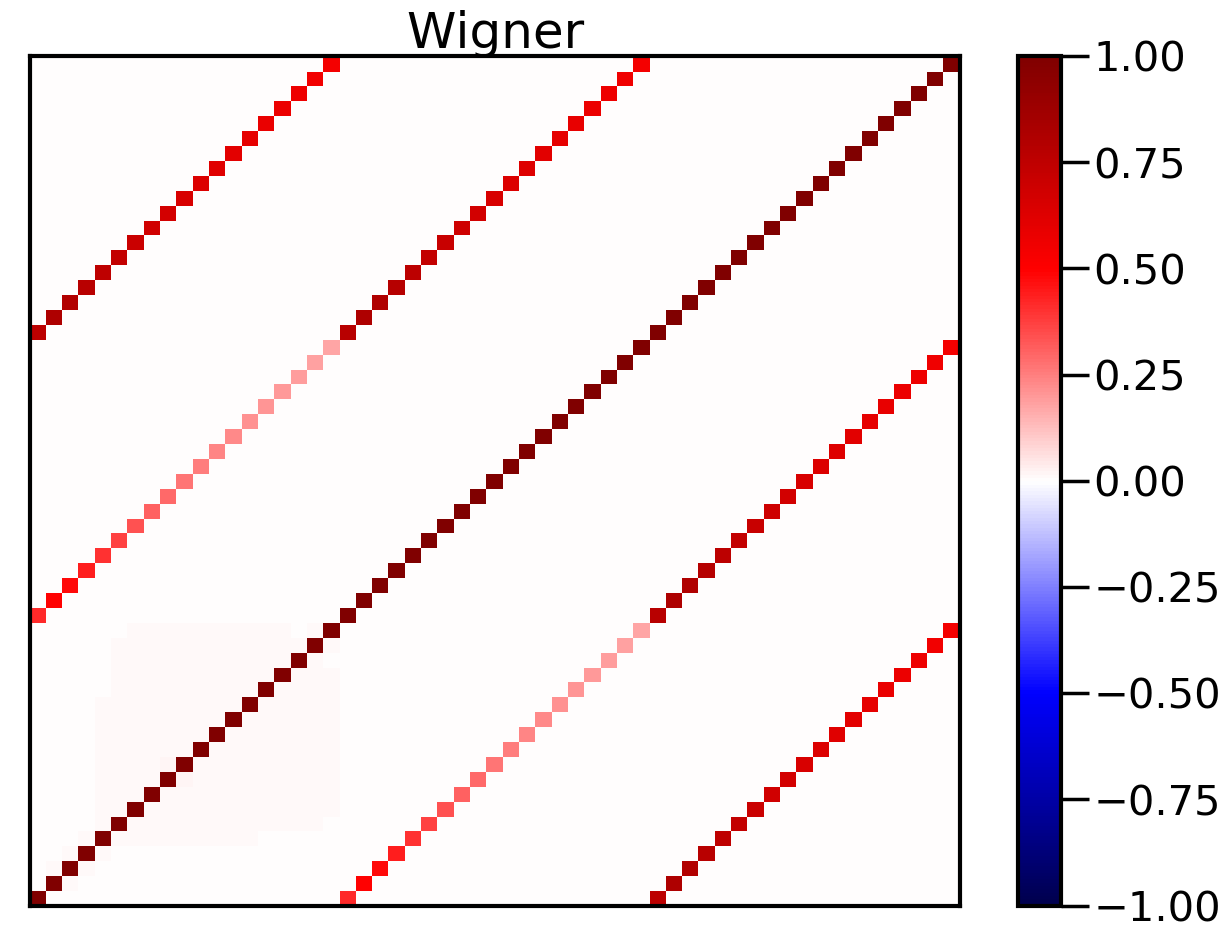

In [66]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [67]:
linalg.cond(cl_L['cov']) #< 1/sys.float_info.epsilon

565717922.4678873

In [68]:
N=np.linalg.norm(cl_L['cov'])
np.linalg.det(cl_L['cov']*5.e20)

105681116312198.84

In [69]:
cov_inv=np.linalg.inv(cl_L['cov'])
cov_nw_inv=np.linalg.inv(cl_L_nw['cov'])
SN=cl_L['cl_b']@cov_inv@cl_L['cl_b']
SN_nw=cl_L_nw['cl_b']@cov_nw_inv@cl_L_nw['cl_b']
SN,SN_nw,SN/SN_nw

(315224.7824079658, 317464.11734524067, 0.9929461793792601)

In [75]:
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

added extra corr calc for covariance [('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 6.82 s, sys: 44.9 ms, total: 6.87 s
Wall time: 1.34 s
added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 6.69 s, sys: 36.6 ms, total: 6.73 s
Wall time: 1.19 s


In [76]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

CPU times: user 1min 8s, sys: 412 ms, total: 1min 8s
Wall time: 9.16 s
CPU times: user 56.3 s, sys: 321 ms, total: 56.6 s
Wall time: 7.03 s


In [77]:
XI_W_L.corrs

[('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy')]

In [78]:
XI_W_L.Win.Win.keys()

dict_keys(['cl', 'cov'])

In [79]:
f=1
xiW_L_nw_inv=np.linalg.inv(xiW_L_nw['cov']*f)
print ((np.dot(xiW_L_nw['xi'],np.dot(xiW_L_nw_inv,xiW_L_nw['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print ((np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

862977.5504203012
-1194059206.8237703


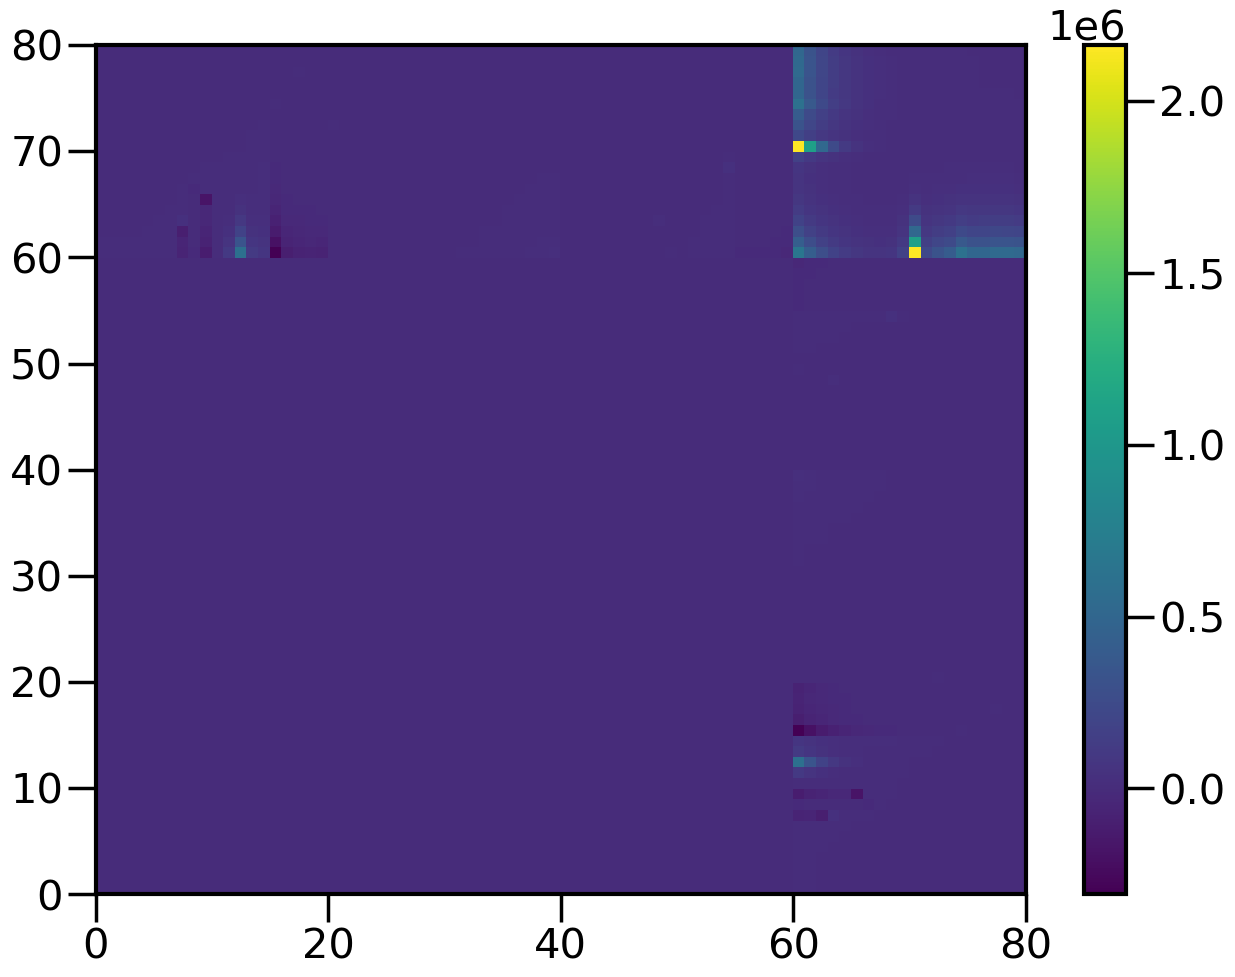

In [80]:
pcolor(xiW_L_nw['cov']/xiW_L['cov'])
colorbar()

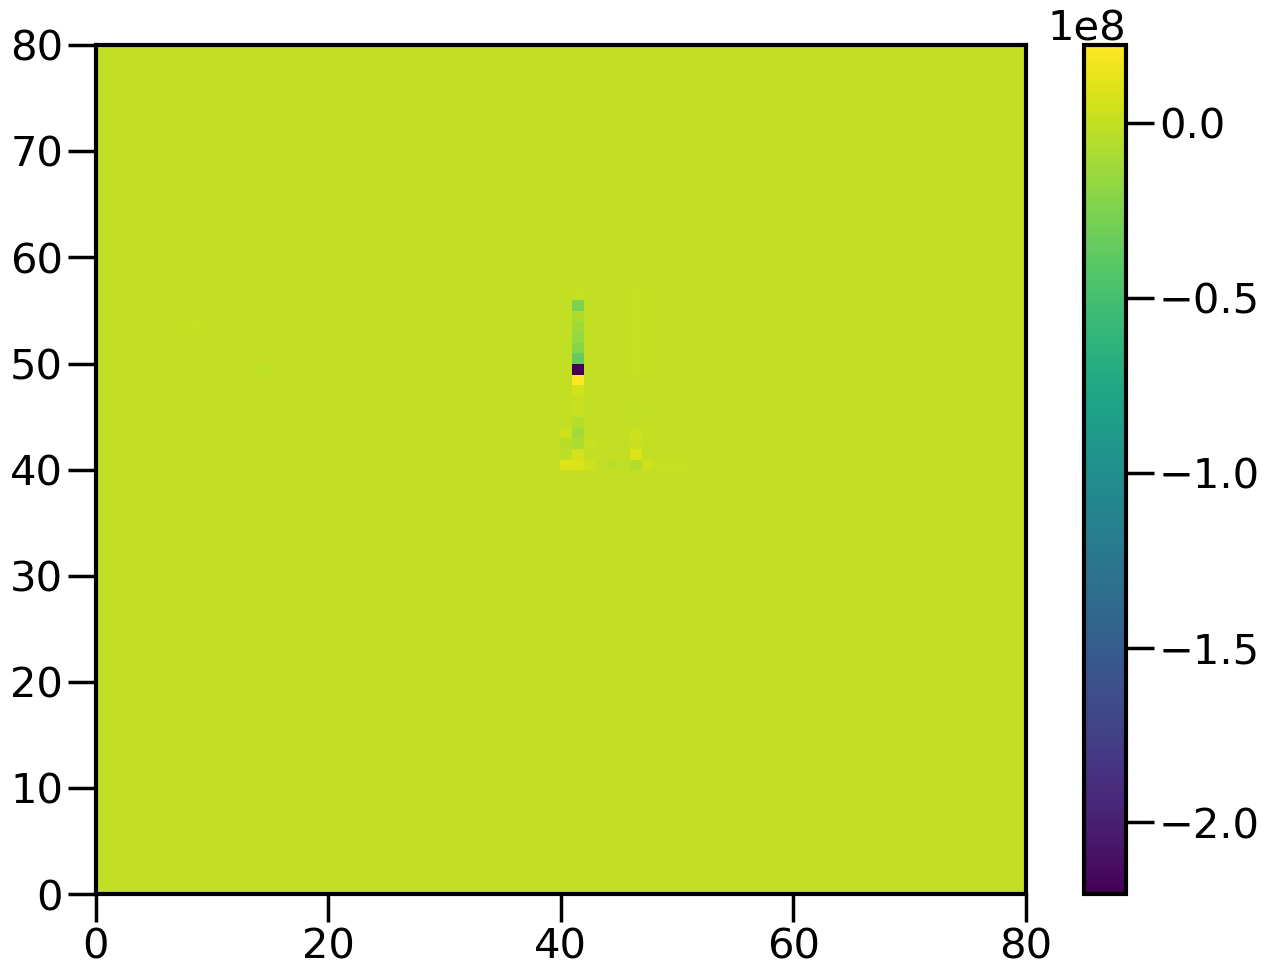

In [81]:
pcolor(xiW_L_nw_inv/cov_xiWL_inv)
colorbar()

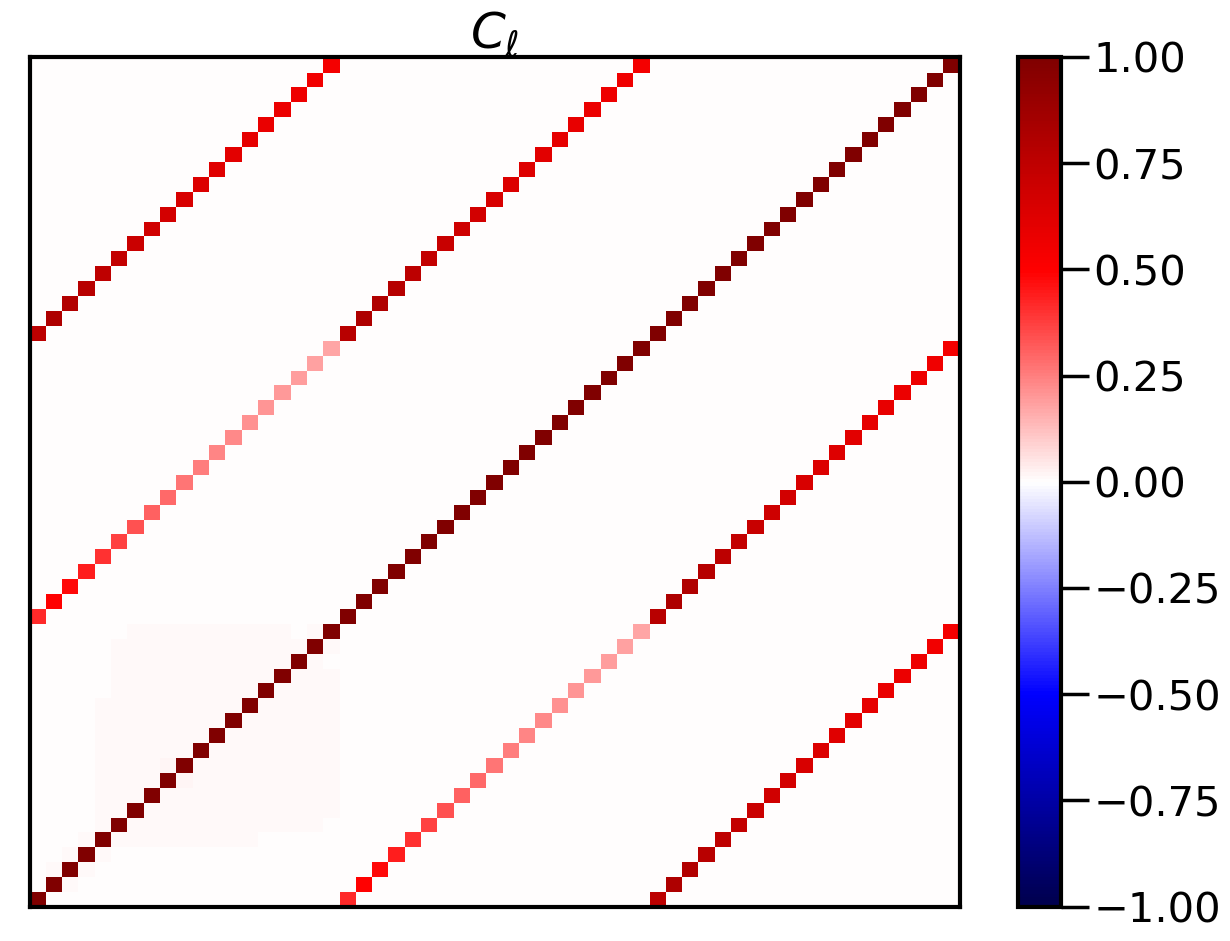

In [82]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

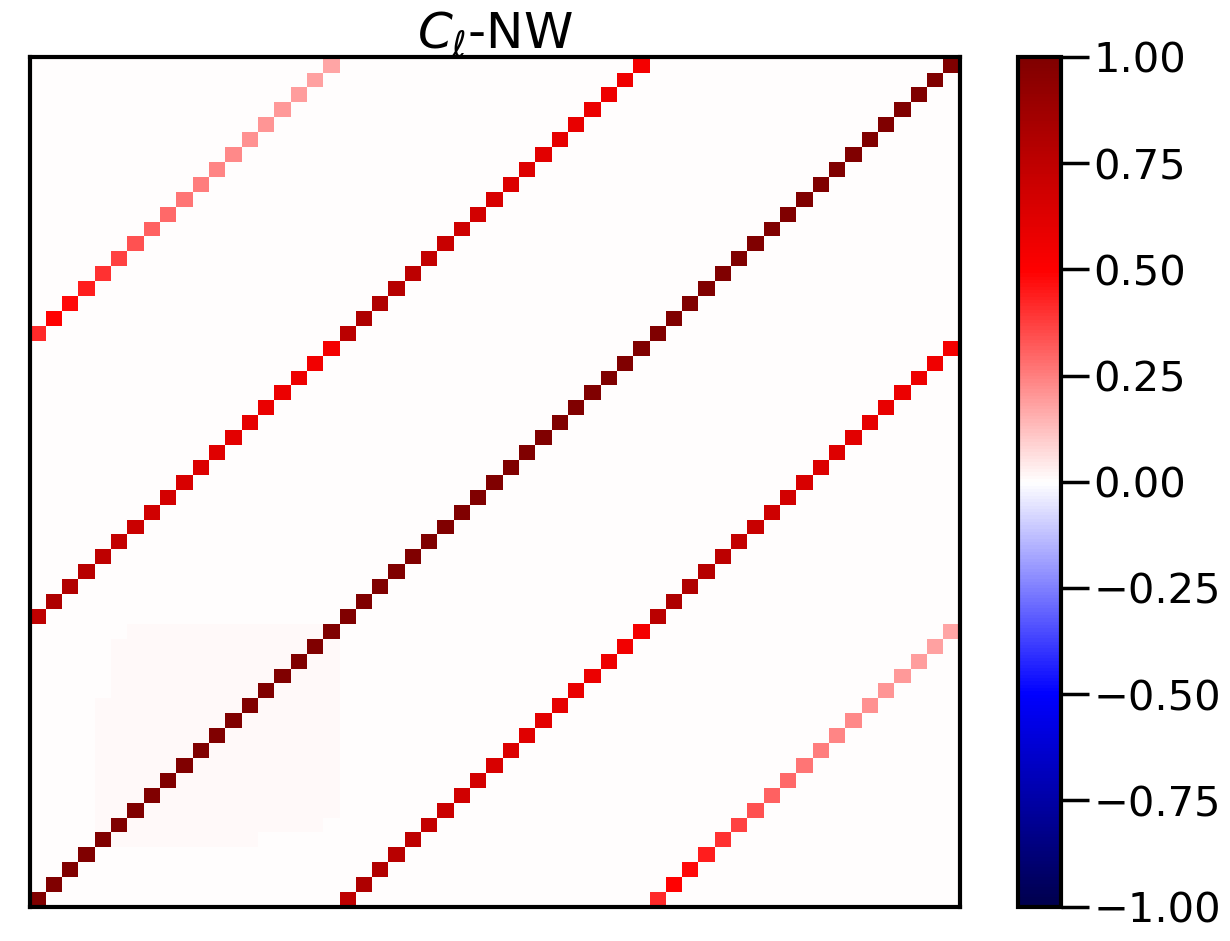

In [83]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


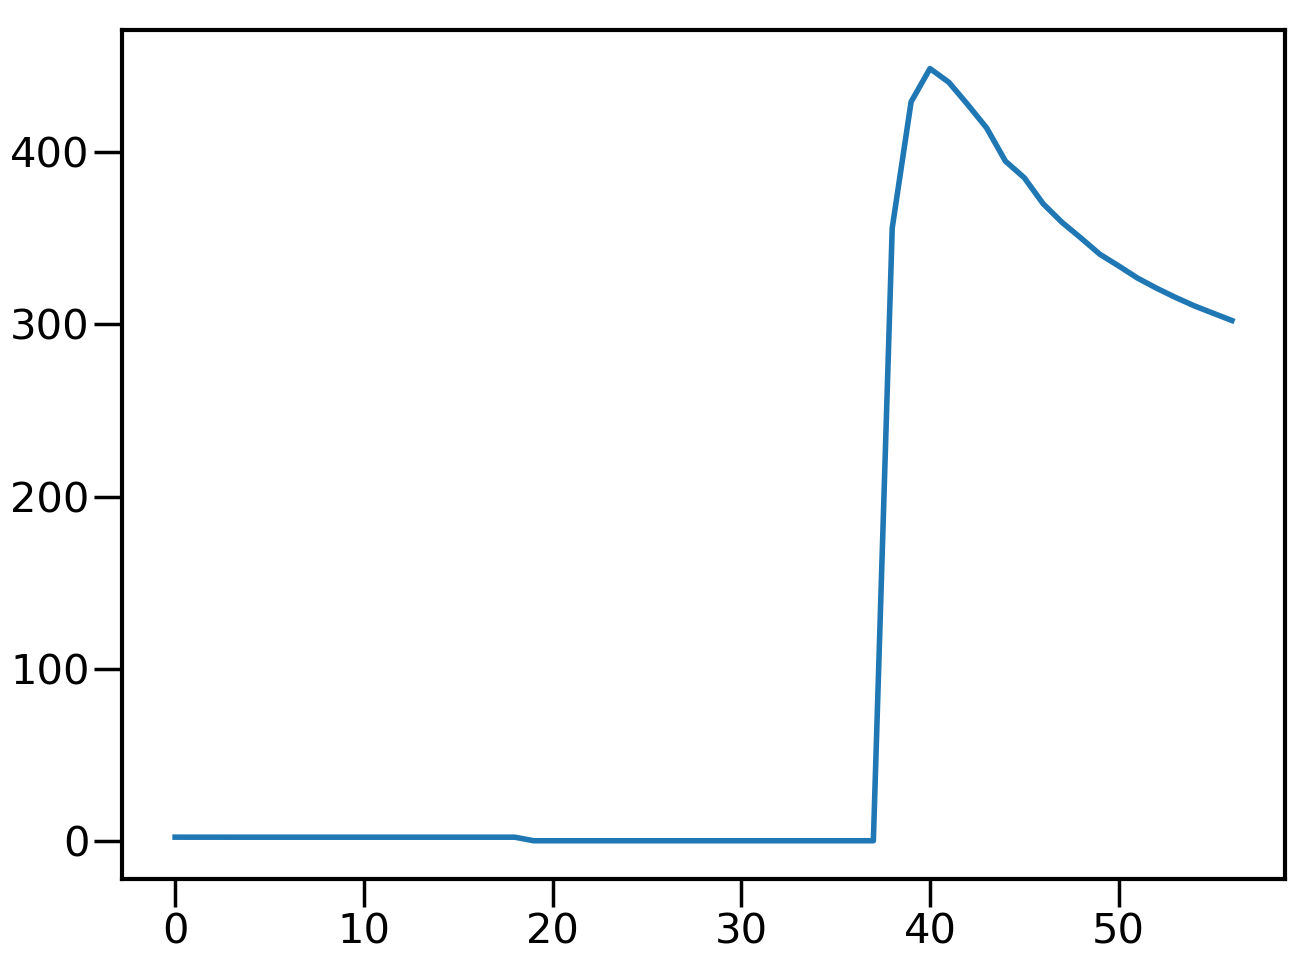

In [84]:
R=np.diag(cl_L_nw['cov']/cl_L['cov'])
plot(R)

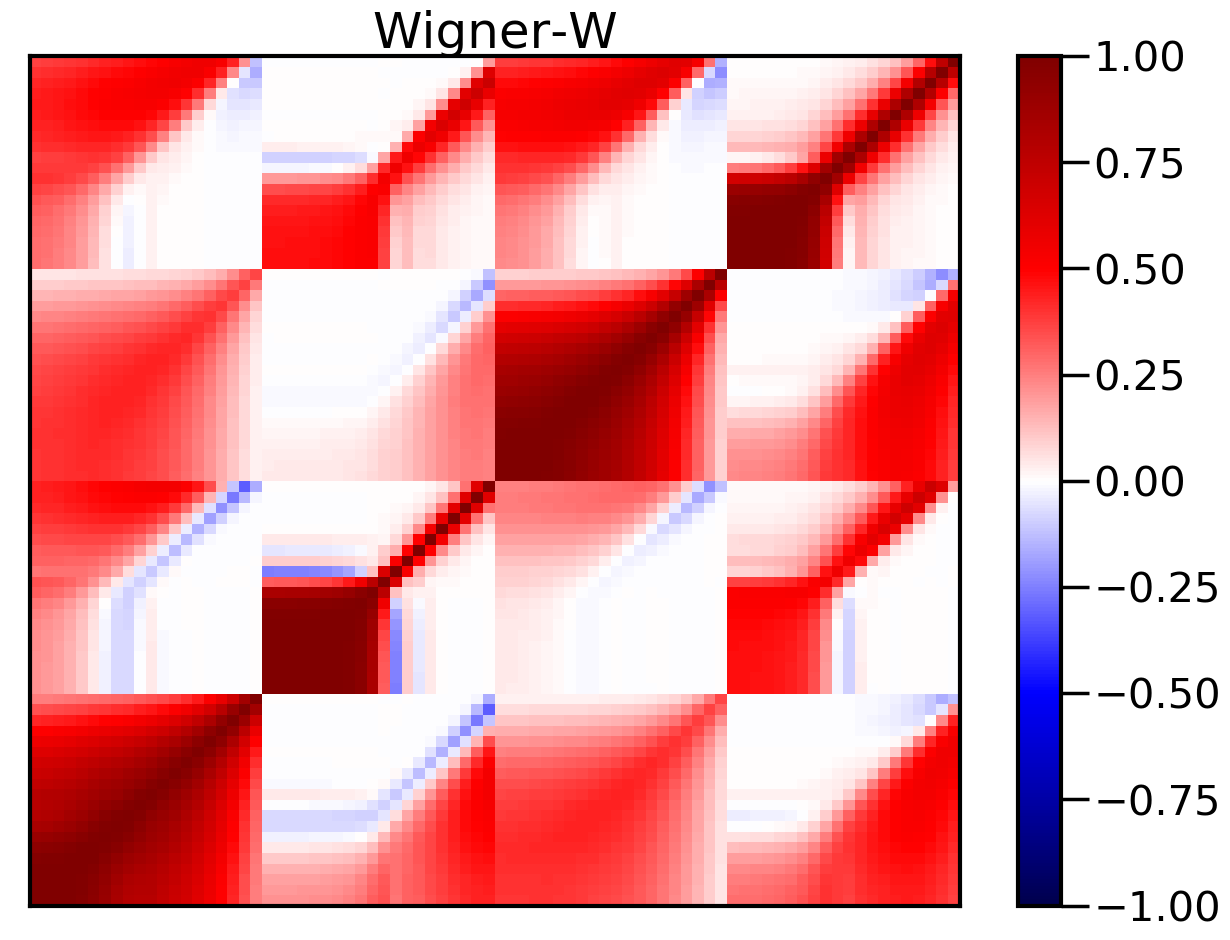

In [95]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-W')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

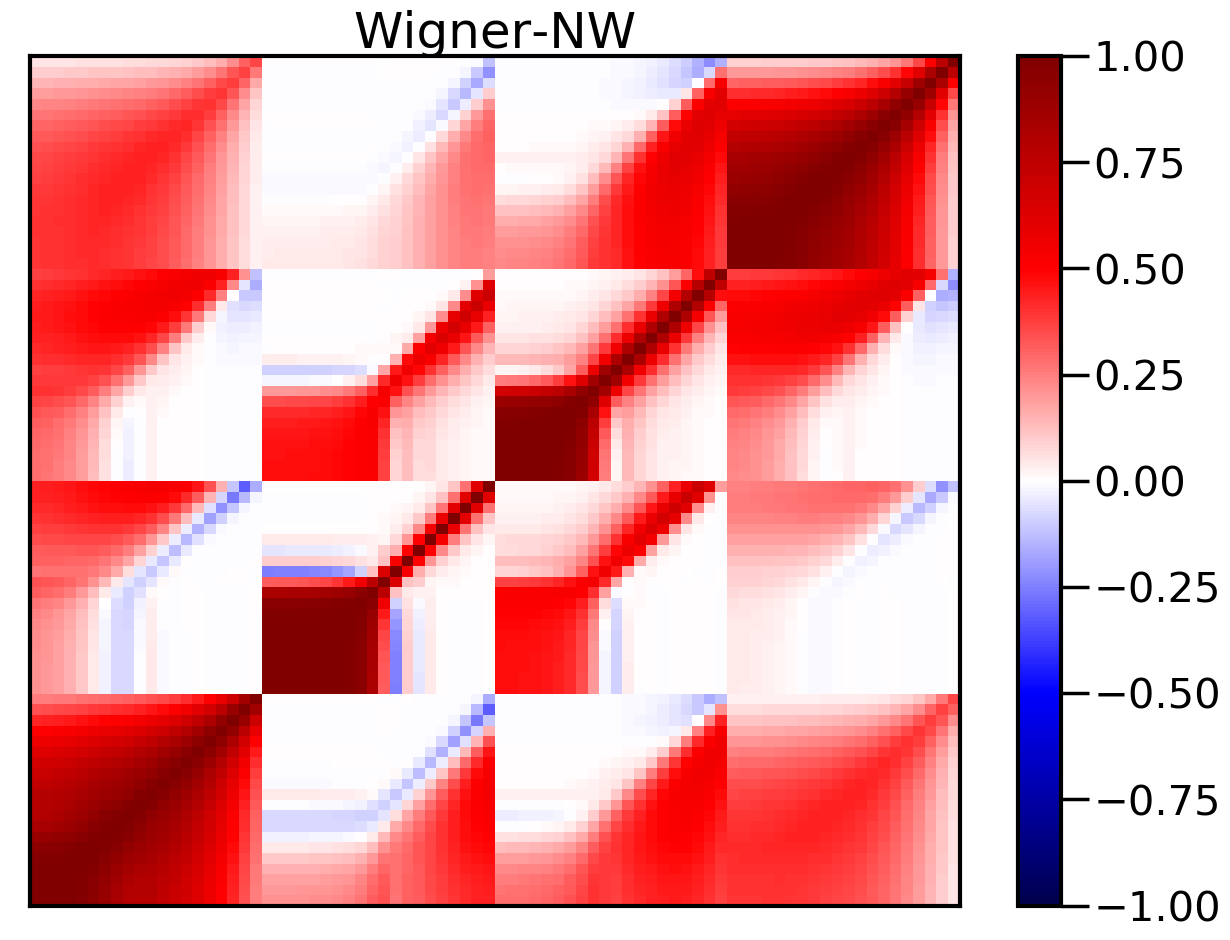

In [94]:
cc=XI_W_L.cov_utils
corrNW=cc.corr_matrix(xiW_L_nw['cov'])
pcolor(corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

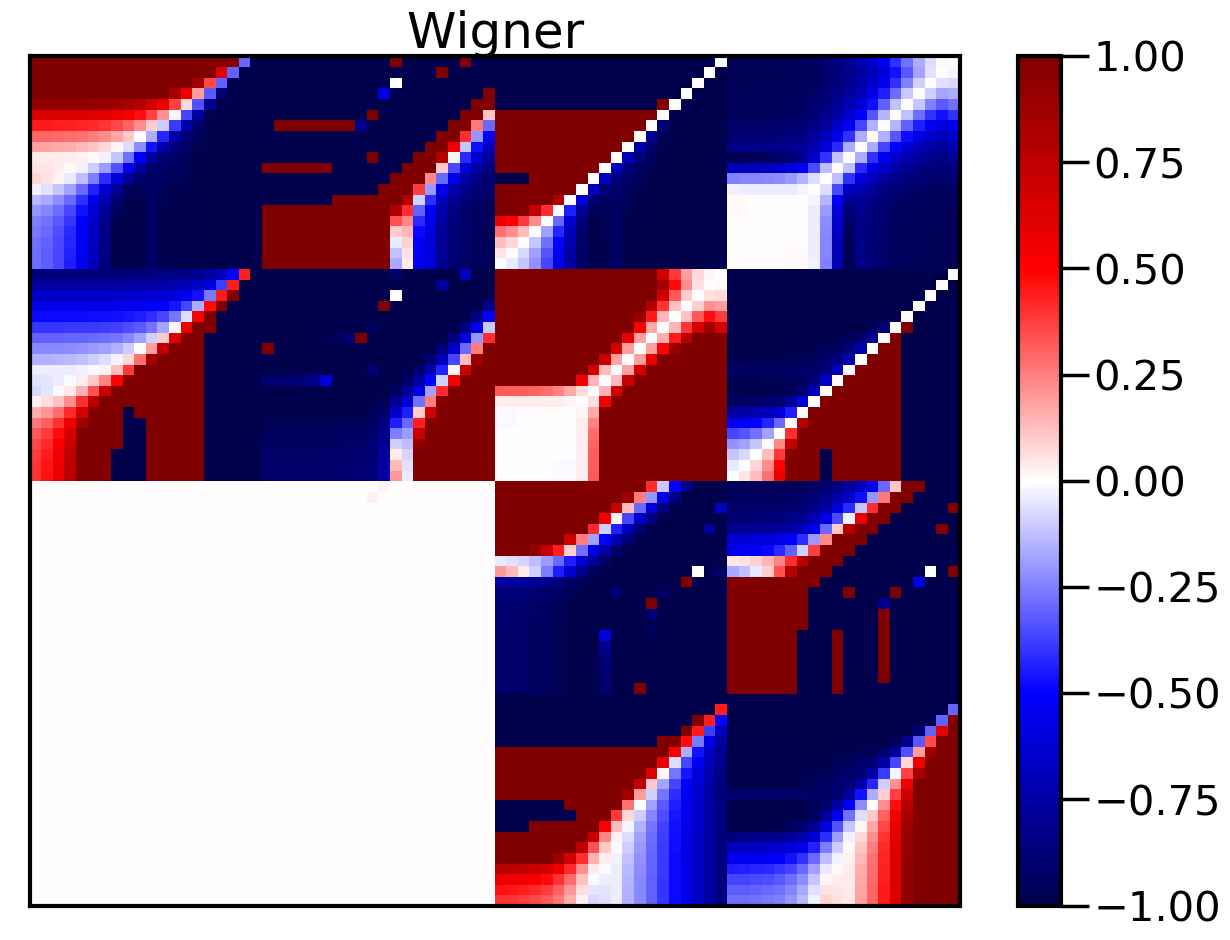

In [87]:
pcolor(corrW/corrNW-1,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [88]:
XI_W_L.cov_utils.gaussian_cov_norm_2D

array([[1.00000000e+00, 1.73205081e+00, 2.23606798e+00, ...,
        4.46654229e+01, 4.46878059e+01, 4.47101778e+01],
       [1.73205081e+00, 3.00000000e+00, 3.87298335e+00, ...,
        7.73627817e+01, 7.74015504e+01, 7.74402996e+01],
       [2.23606798e+00, 3.87298335e+00, 5.00000000e+00, ...,
        9.98749218e+01, 9.99249719e+01, 9.99749969e+01],
       ...,
       [4.46654229e+01, 7.73627817e+01, 9.98749218e+01, ...,
        1.99500000e+03, 1.99599975e+03, 1.99699900e+03],
       [4.46878059e+01, 7.74015504e+01, 9.99249719e+01, ...,
        1.99599975e+03, 1.99700000e+03, 1.99799975e+03],
       [4.47101778e+01, 7.74402996e+01, 9.99749969e+01, ...,
        1.99699900e+03, 1.99799975e+03, 1.99900000e+03]])

In [89]:
np.diag(xiW_L_nw['cov'])/np.diag(xiW_L['cov'])

array([9.93175289e-01, 9.93174605e-01, 9.93173524e-01, 9.93171831e-01,
       9.93169177e-01, 9.93165039e-01, 9.93158595e-01, 9.93148484e-01,
       9.93132475e-01, 9.93106947e-01, 9.93066584e-01, 9.93003002e-01,
       9.92902480e-01, 9.92743836e-01, 9.92493173e-01, 9.92098639e-01,
       9.91481708e-01, 9.90522162e-01, 9.89050468e-01, 9.86831783e-01,
       9.93177419e-01, 9.93176802e-01, 9.93175821e-01, 9.93174273e-01,
       9.93171818e-01, 9.93167917e-01, 9.93161709e-01, 9.93151799e-01,
       9.93135897e-01, 9.93110029e-01, 9.93069571e-01, 9.93006126e-01,
       9.92906325e-01, 9.92748382e-01, 9.92499061e-01, 9.92107913e-01,
       9.91496318e-01, 9.90545133e-01, 9.89085099e-01, 9.86882486e-01,
       1.49878048e-06, 3.66189069e-06, 8.74334975e-06, 2.00888026e-05,
       4.35565776e-05, 8.57137275e-05, 1.44502347e-04, 1.96618541e-04,
       2.22871443e-04, 2.66936409e-04, 3.35422481e-04, 4.25932486e-04,
       5.53827525e-04, 7.37513826e-04, 9.95697268e-04, 1.35250892e-03,
      

In [90]:
5.25/1.93

2.7202072538860103

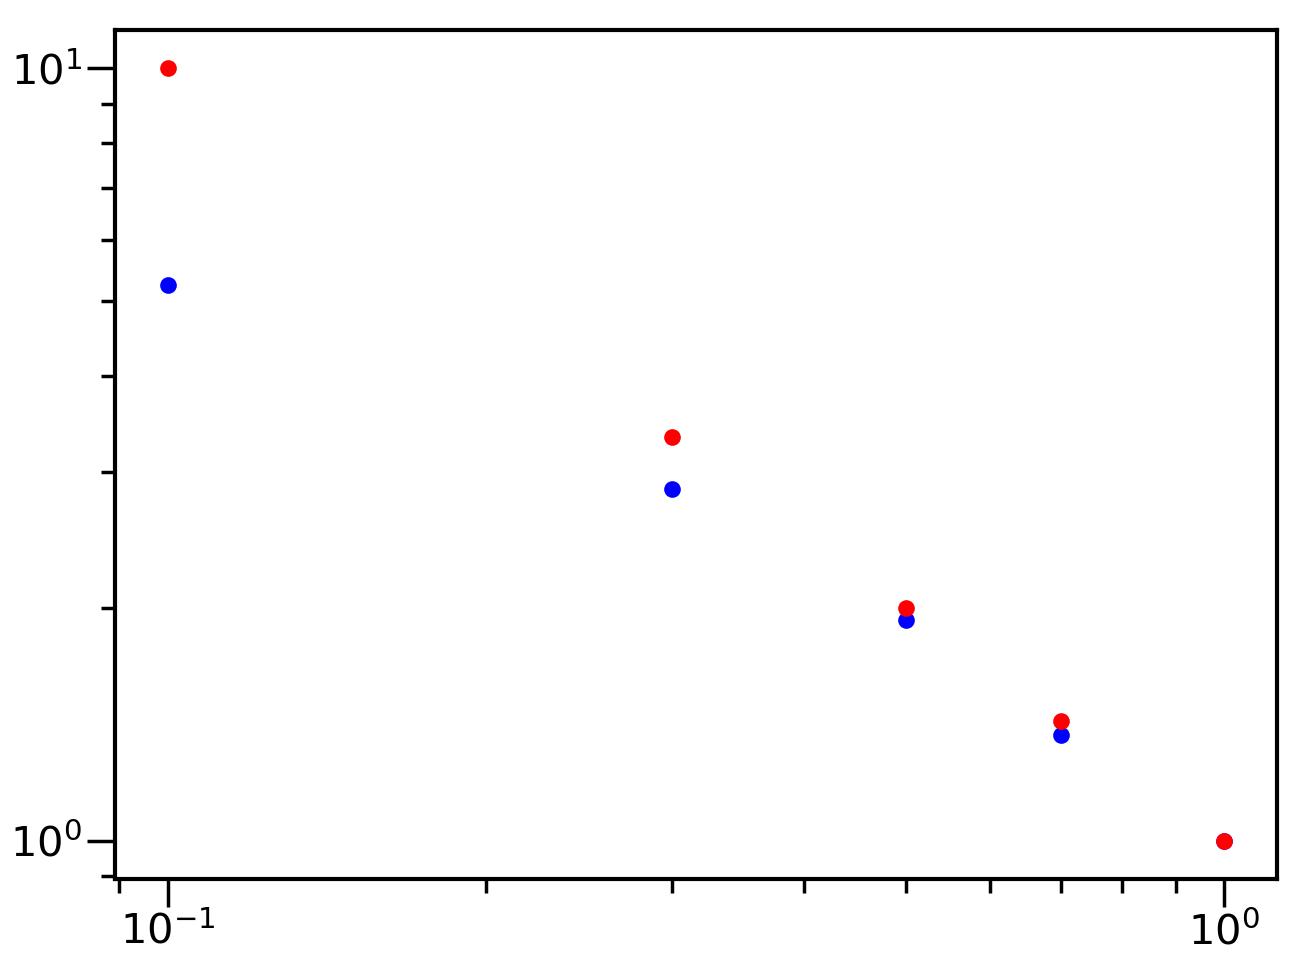

In [91]:
x=np.array([1,0.5,0.1,0.3,0.7])
plot(x,[1,1.93,5.25,2.85,1.37],'bo')
plot(x,1./x,'ro')
yscale('log')
xscale('log')

In [92]:
xiW_L_nw['cov']/xiW_L['cov']

array([[  0.99317529,   0.99317527,   0.99317523, ...,   6.69146001,
          4.14912726,   2.08377855],
       [  0.99317463,   0.9931746 ,   0.99317457, ...,   6.69432304,
          4.15044283,   2.08427621],
       [  0.99317358,   0.99317356,   0.99317352, ...,   6.6988372 ,
          4.15251932,   2.08507878],
       ...,
       [  6.69146001,   6.69432304,   6.6988372 , ..., 393.76009655,
        362.71368296, 323.60633321],
       [  4.14912726,   4.15044283,   4.15251932, ..., 362.14042222,
        296.24944818, 264.80670588],
       [  2.08377855,   2.08427621,   2.08507878, ..., 322.34893697,
        264.16803083, 228.96842038]])

In [93]:
xiW_L_nw['xi']/xiW_L['xi']

array([1.00153520e+00, 1.00155698e+00, 1.00159377e+00, 1.00165783e+00,
       1.00177533e+00, 1.00200544e+00, 1.00249077e+00, 1.00354731e+00,
       1.00536971e+00, 1.00635490e+00, 1.00604560e+00, 1.00782144e+00,
       1.01065929e+00, 1.01213432e+00, 1.01567253e+00, 1.02094579e+00,
       1.02791758e+00, 1.03875230e+00, 1.05454852e+00, 1.08334501e+00,
       1.00133012e+00, 1.00132150e+00, 1.00130785e+00, 1.00128619e+00,
       1.00125165e+00, 1.00119636e+00, 1.00110727e+00, 1.00096238e+00,
       1.00072359e+00, 1.00032234e+00, 9.99703318e-01, 9.99558630e-01,
       1.00027087e+00, 9.99419857e-01, 9.99645435e-01, 9.99464040e-01,
       9.99020814e-01, 9.98785676e-01, 9.97879229e-01, 9.96815583e-01,
       1.36854893e-03, 2.19210047e-03, 3.52285329e-03, 5.68757078e-03,
       9.27253854e-03, 1.53052640e-02, 2.54791729e-02, 4.12299635e-02,
       5.54775170e-02, 4.63220383e-02, 3.25486140e-02, 5.07317933e-02,
       6.06953724e-02, 6.78606810e-02, 8.08355093e-02, 1.09242832e-01,
      